# palomar_sites
Read kml file and create telescope array for corsika

# Imports

In [80]:
# imports
import numpy as np
import itertools
from pykml import parser
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
import matplotlib.cm as colormaps
from scipy.spatial.distance import pdist
import astropy.units as u
from astropy.coordinates import SkyCoord

# Read KML file

In [81]:
filename='PANOSETI Sites at Palomar - Jan 2025.kml'
with open(filename, 'r', encoding="utf-8") as f:
   root = parser.parse(f).getroot()


name=[]
long=[]
lat=[]
alt=[]

for pm in root.Document.Placemark:
    name.append(pm.name.text)
    coords=pm.Point.coordinates.text.split(',')
    long.append(float(coords[0]))
    lat.append(float(coords[1]))
    alt.append(float(coords[2]))

df=pd.DataFrame()
df['site_name']=name
df['longitude']=long
df['latitude']=lat
df['altitude']=alt

In [82]:
# convert to positions
reference=[-116.86484,33.35632,1650] # 200-inch, roughly

# assuming flat ground - okay under 100km
R = 6371000+1650
df['X']=np.radians(df.longitude - reference[0]) * R * np.cos(np.radians(reference[1]))
df['Y']=np.radians(df.latitude - reference[1]) * R
df['Z']=df.altitude - reference[2]

# arbitrary offset
df.X = df.X - 100
df.Y = df.Y + 150


In [83]:
# priority

# 0 - aspirational (blue)
# 1 - green
# 2 - yellow
# 3 - salmon

df['priority'] = [1,1,2,2,2,1,1,2,2,1,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

color={
    0: 'tab:blue',
    1: 'green',
    2: 'yellow',
    3: 'salmon',
}

df['color'] = df.priority.apply(lambda x: color[x])

In [84]:
df['distance'] = np.hypot(df.X,df.Y)

In [85]:
df

site_name   longitude   latitude     altitude           X  \
0       Ferns-North -116.865566  33.358478  1684.662094 -167.412855   
1            Winter -116.866163  33.356923  1699.172001 -222.895597   
2          PTI-Heli -116.864617  33.357401  1689.703579  -79.281409   
3     200-inch East -116.863027  33.356242  1687.218656   68.447065   
4   Monastery North -116.860950  33.354720  1670.916636  261.386985   
5            Oschin -116.860098  33.357189  1693.061619  340.524990   
6        Dog Seismo -116.862590  33.353626  1692.817564  109.031257   
7    18-inch North  -116.862797  33.354718  1689.122326   89.787228   
8   Monastery South -116.860293  33.353529  1673.784392  322.380286   
9      60-inch West -116.860090  33.348596  1678.859954  341.252572   
10        NWS South -116.862783  33.351570  1651.268068   91.129896   
11      Gravel Pile -116.859781  33.350051  1673.466351  370.001629   
12   Southern Edge? -116.858447  33.347863  1655.595703  493.910733   
13       East Side? -116.865322  33.352077  1651.604392 -144.821485   
14        Dirt Fork -116.861165  33.352536  1676.101458  241.441836   
15       East Road? -116.864068  33.353965  1685.235066  -28.312933   
16     Gentle Bend? -116.861299  33.355320  1673.871312  228.935289   
17        Backyard? -116.860656  33.356654  1677.864708  288.726018   
18     Oschin-East? -116.858609  33.357003  1677.514190  478.909288   
19          Office? -116.861854  33.357904  1696.042077  177.393452   
20   East of Ferns? -116.863966  33.358170  1684.853360  -18.764160   
21   200-inch West? -116.866215  33.355809  1686.966180 -227.695361   
22            Gate? -116.867517  33.357833  1695.225857 -348.689933   
23          Picnic? -116.867096  33.359508  1679.329776 -309.611816   
24      North House -116.864826  33.360933  1665.994279  -98.716299   
25        Outreach? -116.871118  33.360761  1663.533250 -683.217886   

             Y          Z  priority     color    distance  
0   390.006954  34.662094         1     green  424.420179  
1   217.090243  49.172001         1     green  311.144051  
2   270.253881  39.703579         2    yellow  281.642862  
3   141.308525  37.218656         2    yellow  157.013057  
4   -27.957959  20.916636         2    yellow  262.877925  
5   246.663594  43.061619         1     green  420.476155  
6  -149.589017  42.817564         1     green  185.107236  
7   -28.230787  39.122326         2    yellow   94.120793  
8  -160.406583  23.784392         2    yellow  360.082381  
9  -709.074254  28.859954         1     green  786.917795  
10 -378.259008   1.268068         3    salmon  389.081656  
11 -547.213607  23.466351         3    salmon  660.563349  
12 -790.588647   5.595703         0  tab:blue  932.190014  
13 -321.927199   1.604392         0  tab:blue  353.001960  
14 -270.825393  26.101458         0  tab:blue  362.823033  
15 -111.903192  35.235066         0  tab:blue  115.429401  
16   38.750412  23.871312         0  tab:blue  232.191647  
17  187.171625  27.864708         0  tab:blue  344.087098  
18  225.955087  27.514190         0  tab:blue  529.537353  
19  326.133823  46.042077         0  tab:blue  371.256929  
20  355.740812  34.853360         0  tab:blue  356.235343  
21   93.182700  36.966180         0  tab:blue  246.024781  
22  318.240707  45.225857         0  tab:blue  472.082426  
23  504.598818  29.329776         0  tab:blue  592.013044  
24  663.074394  15.994279         0  tab:blue  670.382398  
25  643.953322  13.533250         0  tab:blue  938.862376

# Plotting

In [86]:
def plotArray(ax, highlight=None):

    plt.title('PANOSETI @ Palomar')

    if(highlight is not None):
        for t in range(len(df)):
            scope=df.iloc[t]
            if t not in highlight.index.to_list():
                ax.scatter(scope.X,scope.Y,color='grey',s=50)
            else:
                ax.scatter(scope.X,scope.Y,color=scope.color,edgecolor='black',s=50)
    else:
        ax.scatter(df.X,df.Y,color=df.color,edgecolor='black',s=50)

    ax.set_xlim(-1500,1500)
    ax.set_ylim(-1500,1500)
    ax.set_xlabel('Eastings (m)')
    ax.set_ylabel('Northings (m)')

    ax.add_patch(Circle([0,0],1200,facecolor='None', edgecolor='black', lw=1))

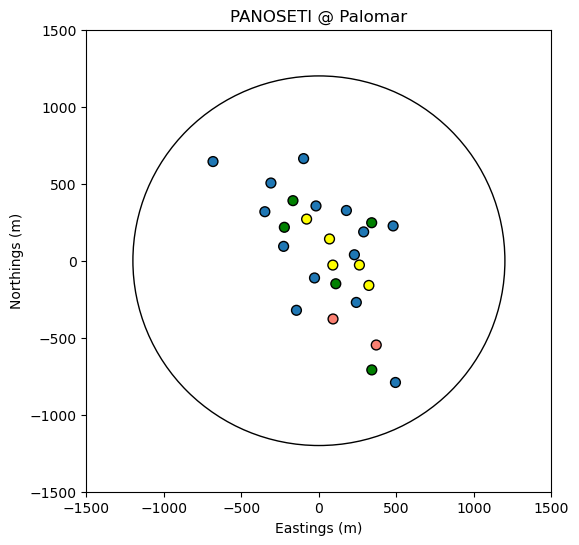

In [87]:
fig=plt.figure(figsize=(6,6))
ax=plt.subplot()
plotArray(ax)

# CORSIKA locations

In [88]:
# CORSIKA: X(N), Y(W)

for t in range(len(df)):
    print('TELESCOPE {:.1f} {:.1f} {:.1f} 25.'.format(100*df.Y[t],-100*df.X[t],100*df.Z[t]))

TELESCOPE 39000.7 16741.3 3466.2 25.
TELESCOPE 21709.0 22289.6 4917.2 25.
TELESCOPE 27025.4 7928.1 3970.4 25.
TELESCOPE 14130.9 -6844.7 3721.9 25.
TELESCOPE -2795.8 -26138.7 2091.7 25.
TELESCOPE 24666.4 -34052.5 4306.2 25.
TELESCOPE -14958.9 -10903.1 4281.8 25.
TELESCOPE -2823.1 -8978.7 3912.2 25.
TELESCOPE -16040.7 -32238.0 2378.4 25.
TELESCOPE -70907.4 -34125.3 2886.0 25.
TELESCOPE -37825.9 -9113.0 126.8 25.
TELESCOPE -54721.4 -37000.2 2346.6 25.
TELESCOPE -79058.9 -49391.1 559.6 25.
TELESCOPE -32192.7 14482.1 160.4 25.
TELESCOPE -27082.5 -24144.2 2610.1 25.
TELESCOPE -11190.3 2831.3 3523.5 25.
TELESCOPE 3875.0 -22893.5 2387.1 25.
TELESCOPE 18717.2 -28872.6 2786.5 25.
TELESCOPE 22595.5 -47890.9 2751.4 25.
TELESCOPE 32613.4 -17739.3 4604.2 25.
TELESCOPE 35574.1 1876.4 3485.3 25.
TELESCOPE 9318.3 22769.5 3696.6 25.
TELESCOPE 31824.1 34869.0 4522.6 25.
TELESCOPE 50459.9 30961.2 2933.0 25.
TELESCOPE 66307.4 9871.6 1599.4 25.
TELESCOPE 64395.3 68321.8 1353.3 25.


## Layouts

26 choose 3 is already 2600, so 5,6,7, etc... will explode. Lets restrict to some characteristic size (Cherenkov light pool)

In [89]:
n_tel=3

limit=300
# limit=500
# limit=1000
# limit=1e4

In [90]:
def telescopes_within_limit(points,limit):
    distances = pdist(points)
    if np.max(distances) < limit:
        return True


In [91]:
n_valid=0

valid_arrays=[]

for i in itertools.combinations(np.arange(0,len(df)),n_tel):
    
    array=df.iloc[list(i)]
    
    points=[]
    for j in range(len(array)):
        telescope = array.iloc[j]
        points.append((telescope.X,telescope.Y))

    if(telescopes_within_limit(points,limit)):
        n_valid +=1
        valid_arrays.append(array)

print(n_valid)

67


## Read in data (sims)

In [92]:
f1 = "../data/palomar/palomar-sim-gamma/data/_merged.csv"
f2 = "../data/palomar/palomar-sim-gamma-2/data/_merged.csv"
f3 = "../data/palomar/palomar-sim-gamma/data/_merged.2pixtrig.csv"
f4 = "../data/palomar/palomar-sim-gamma-low-energy/data/_merged.csv"

files = [f1,f2]
# files=[f4]

buffer=0
frames=[]
for f in files:
    temp = pd.read_csv(f)
    temp["Event"]=temp["Event"]+buffer
    buffer+=len(temp)
    frames.append(temp)

df_sims = pd.concat(frames, ignore_index=True)

In [93]:
df_sims.describe()

/home/nkorzoun/Software/miniconda3/envs/panoseti/lib/python3.11/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


Event     Telescope         MeanX          StdX         MeanY  \
count  4.368832e+06  4.368832e+06  4.368832e+06  4.368832e+06  4.368832e+06   
mean   1.120841e+06  1.350000e+01  4.872113e-06  3.314374e-03 -2.888003e-05   
std    1.232420e+06  7.500001e+00  9.165250e-02  3.033542e-02  9.030246e-02   
min    1.000000e+00  1.000000e+00 -4.680080e+00  0.000000e+00 -4.188120e+00   
25%    4.590875e+04  7.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
50%    8.806150e+04  1.350000e+01  0.000000e+00  0.000000e+00  0.000000e+00   
75%    2.526975e+06  2.000000e+01  0.000000e+00  0.000000e+00  0.000000e+00   
max    2.592126e+06  2.600000e+01  3.912020e+00  9.879910e-01  4.020520e+00   

               StdY           Phi          Size        Length         Width  \
count  4.368832e+06  56932.000000  4.368832e+06  4.368832e+06  4.368768e+06   
mean   3.298879e-03    180.487434  4.231884e+01  4.098900e-03  2.378467e-03   
std    3.013430e-02    137.680064  2.863467e+03  3.717076e-02  2.112023e-02   
min    0.000000e+00      0.000000  0.000000e+00  0.000000e+00  0.000000e+00   
25%    0.000000e+00     45.029400  0.000000e+00  0.000000e+00  0.000000e+00   
50%    0.000000e+00    270.196500  0.000000e+00  0.000000e+00  0.000000e+00   
75%    0.000000e+00    315.208750  0.000000e+00  0.000000e+00  0.000000e+00   
max    1.060480e+00    360.000000  5.171540e+06  1.204240e+00  8.539460e-01   

       ...             Az             Ze          Xcore          Ycore  \
count  ...  374738.000000  374738.000000  374738.000000  374738.000000   
mean   ...     180.339525      14.231538      24.228646      27.346191   
std    ...     104.229788       4.751446    7647.784527    4681.511103   
min    ...       0.000213       0.182920 -904899.000000  -99999.000000   
25%    ...      89.635600      11.228600     -92.227300    -197.551000   
50%    ...     179.741000      14.869600     119.762000      77.566600   
75%    ...     271.555000      17.688900     300.202000     272.847000   
max    ...     359.989000      96.873600   29982.700000  535096.000000   

               stdP        TrueAz        TrueZe     TrueXcore     TrueYcore  \
count  3.747380e+05  4.368832e+06  4.368832e+06  4.368832e+06  4.368832e+06   
mean            inf  1.913377e+02  1.328556e+01 -9.078322e-01  1.398180e+00   
std             NaN  1.039079e+02  4.716446e+00  7.031298e+02  7.040164e+02   
min    0.000000e+00  1.103040e+01  6.257090e-02 -1.725560e+03 -1.711720e+03   
25%    1.259170e-09  1.012875e+02  9.930423e+00 -5.592670e+02 -5.561570e+02   
50%    6.710400e-07  1.913780e+02  1.408680e+01 -1.016719e+00  3.870630e+00   
75%    1.126210e+00  2.816058e+02  1.725850e+01  5.571282e+02  5.623228e+02   
max             inf  3.710300e+02  1.999990e+01  1.714420e+03  1.740720e+03   

         TrueEnergy  
count  4.368832e+06  
mean   2.846727e+04  
std    7.831001e+04  
min    1.000000e+04  
25%    1.210405e+04  
50%    1.583075e+04  
75%    2.514920e+04  
max    7.885390e+06  

[8 rows x 24 columns]

In [94]:
df_sims.Event.nunique()

168032

## Cleaning data

In [95]:
# remove nans
sims=df_sims[['Event','Telescope','MeanX','MeanY','Phi','Size','Length','Width','TrueAz','TrueZe','TrueEnergy']]
sims=sims.dropna(subset=["Length", "Width"])
sims=sims[sims["Width"]>0]

In [96]:
sims.Event.nunique()

32266

In [97]:
sims.describe()

Event     Telescope         MeanX         MeanY           Phi  \
count  5.682900e+04  56829.000000  56829.000000  56829.000000  56829.000000   
mean   1.115957e+06     13.528093      0.000523     -0.001732    180.542955   
std    1.231497e+06      7.448604      0.801931      0.789792    137.684668   
min    2.000000e+00      1.000000     -4.680080     -4.037180      0.000000   
25%    4.636600e+04      7.000000     -0.655761     -0.650247     45.119800   
50%    8.794600e+04     13.000000      0.004959      0.001383    270.233000   
75%    2.526630e+06     20.000000      0.658919      0.651773    315.266000   
max    2.592124e+06     26.000000      3.912020      4.020520    360.000000   

               Size        Length         Width        TrueAz        TrueZe  \
count  5.682900e+04  56829.000000  5.682900e+04  56829.000000  56829.000000   
mean   3.252707e+03      0.314467  1.828462e-01    191.147395     14.002454   
std    2.489809e+04      0.091598  3.596709e-02    104.081030      4.362994   
min    1.130000e+02      0.149759  3.725290e-09     11.042800      0.092076   
25%    9.240000e+02      0.251526  1.579120e-01    101.083000     11.081100   
50%    1.479000e+03      0.298345  1.839140e-01    190.866000     14.819100   
75%    2.688000e+03      0.358924  2.044650e-01    281.345000     17.645400   
max    5.171540e+06      1.204240  8.539460e-01    371.018000     19.999800   

         TrueEnergy  
count  5.682900e+04  
mean   4.900861e+04  
std    1.616213e+05  
min    1.000020e+04  
25%    1.323870e+04  
50%    1.960120e+04  
75%    3.766640e+04  
max    7.885390e+06

## Reconstruction

In [98]:
def slaDtp2s(xi, eta, raz, decz):
    
    # Calculate sine and cosine of the decz (tangent point declination)
    sdecz = np.sin(decz)
    cdecz = np.cos(decz)
    
    # Denominator for RA calculation
    denom = cdecz - eta * sdecz
    
    # Calculate RA (right ascension)
    ra = (np.arctan2(xi, denom) + raz) % (2 * np.pi)  # Make sure RA is between 0 and 2pi
    
    # Calculate Dec (declination)
    dec = np.arctan2(sdecz + eta * cdecz, np.sqrt(xi**2 + denom**2))
    
    return ra, dec

In [99]:
def reconstruct_direction(df):

    event_list = df.drop_duplicates(subset='Event').Event.to_numpy()

    df['Az'] = np.nan
    df['Ze'] = np.nan

    for e in event_list:

        event = df[df.Event == e]
        NTel = len(event)
        
        # Check that there are enough images
        if NTel < 2:
            continue  # Skip to next iteration in the for loop
            
        m = []
        x = []
        y = []
        s = []
        l = []

        # Get relevant image parameters
        for t in range(NTel):
            tel = event.iloc[t]

            s.append(tel.Size)
            x.append(tel.MeanX)
            y.append(tel.MeanY)
            phi_rad = tel.Phi * np.pi / 180
            m.append(np.tan(phi_rad))
            if tel.Length > 0:
                l.append(tel.Width / tel.Length)
            else:
                l.append(1)

        # Direction reconstruction
        itotweight = 0.0
        iweight = 1.0
        ixs = 0.0
        iys = 0.0
        iangdiff = 0.0
        b1 = 0.0
        b2 = 0.0
        v_xs = []
        v_ys = []
        fmean_iangdiff = 0.0
        fmean_iangdiffN = 0.0

        for i in range(NTel):
            for j in range(NTel):
                if i >= j:
                    continue

                # Check minimum angle between image lines; ignore if too small
                iangdiff = np.abs(np.arctan(m[j]) - np.arctan(m[i]))
                if iangdiff < 0 or np.abs(np.pi - iangdiff) < 0:
                    continue
                
                # Mean angle between images
                if iangdiff < np.pi / 2:
                    fmean_iangdiff += iangdiff * 180 / np.pi
                else:
                    fmean_iangdiff += (180 - (iangdiff * 180 / np.pi))
                fmean_iangdiffN += 1

                # Weight is sin of angle between image lines
                iangdiff = np.abs(np.sin(np.abs(np.arctan(m[j]) - np.arctan(m[i]))))

                b1 = y[i] - m[i] * x[i]
                b2 = y[j] - m[j] * x[j]

                # Line intersection
                if m[i] != m[j]:
                    xs = (b2 - b1) / (m[i] - m[j])
                else:
                    xs = 0.0
            
                ys = m[i] * xs + b1

                iweight = 1.0 / (1.0 / s[i] + 1.0 / s[j])  # Weight 1: size of images
                iweight *= (1.0 - l[i]) * (1.0 - l[j])  # Weight 2: elongation of images (width/length)
                iweight *= iangdiff  # Weight 3: angular differences between the two image axes
                iweight *= iweight   # Use squared value

                ixs += xs * iweight
                iys += ys * iweight
                itotweight += iweight
                
                v_xs.append(xs)
                v_ys.append(ys)

        # Average difference between image pairs
        if fmean_iangdiffN > 0.0:
            fmean_iangdiff /= fmean_iangdiffN
        else:
            fmean_iangdiff = 0.0
        
        # Check validity of weight
        if itotweight > 0.0:
            ixs /= itotweight
            iys /= itotweight
            Shower_Xoffset = ixs
            Shower_Yoffset = iys
        else:
            print("Image weights invalid")
            print(e)
            # Shower_Xoffset.append(np.nan)
            # Shower_Yoffset.append(np.nan)

        # Flip the sign of Y offset
        Shower_Yoffset = -1 * Shower_Yoffset

        # Correcting the elevation calculation from TrueAz to TrueZe
        TelAzimuth = event['TrueAz'].values
        TelElevation = 90 - event['TrueZe'].values  # Using TrueZe for zenith angle instead

        az, el = slaDtp2s(-1 * np.deg2rad(Shower_Xoffset), np.deg2rad(Shower_Yoffset), np.deg2rad(TelAzimuth), np.deg2rad(TelElevation))

        az = np.rad2deg(az)  # Convert RA to degrees
        el = np.rad2deg(el)  # Convert Dec to degrees

        df.loc[df.Event == e, 'Az'] = az
        df.loc[df.Event == e, 'Ze'] = 90 - el  # Zenith is complementary to elevation

    return df


## Angular Resolution

In [100]:
def calcPSF(dataframe, threshold=1e4):
    # energy threshold
    dataframe=dataframe[dataframe["TrueEnergy"]>threshold]

    data = dataframe.dropna(subset=["Az","Ze"]).drop_duplicates(subset="Event")
    c1 = SkyCoord(az=data["Az"].values*u.deg, alt=(90-data["Ze"].values)*u.deg, frame='altaz')
    c2 = SkyCoord(az=data["TrueAz"].values*u.deg, alt=(90-data["TrueZe"].values)*u.deg,frame='altaz')
    angle=pd.DataFrame(c1.separation(c2).deg)
    return angle.quantile(0.68)

## Effective Area

In [101]:
def calcEffA(dataframe, threshold=1e4):
    # energy threshold
    dataframe=dataframe[dataframe["TrueEnergy"]>threshold]
    triggeredEvents = dataframe.groupby('Event', group_keys=False).filter(lambda x: len(x) > 1)

    # dataframe=dataframe.drop_duplicates(subset="Event")
    triggeredEvents=triggeredEvents.drop_duplicates(subset="Event")

    all = df_sims[df_sims["TrueEnergy"]>threshold].drop_duplicates(subset="Event")

    # effA = np.pi*1.2*1.2*len(triggeredEvents)/len(dataframe)
    effA = np.pi*1.2*1.2*len(triggeredEvents)/len(all)


    return effA

In [102]:
# test=sims[sims.Telescope.isin([1,2,3])].copy()
# test=reconstruct_direction(test)


# psf=[]
# area=[]

# for e in np.logspace(4,6,21):
#     psf.append(calcPSF(test,threshold=e))
#     area.append(calcEffA(test,threshold=e))


In [103]:
# test.head()

In [104]:
# psf

## Plot

In [105]:
energies = np.logspace(4,6,21)
resolutions = []
areas = []

# calculate
for array in valid_arrays:
    # print(array)
    psf=[]
    area=[]

    data=sims[sims.Telescope.isin(array.index+1)].copy()
    data=reconstruct_direction(data)

    for e in energies:
        psf.append(calcPSF(data,threshold=e))
        area.append(calcEffA(data,threshold=e))

    resolutions.append(psf)
    areas.append(area)

In [106]:
def plotPSF(ax,highlight=None,reference=valid_arrays,color=False):

    plt.xlabel('Energy (TeV)')
    plt.ylabel('Angular Resolution (degrees)')
    ax.set_xscale('log')

    cmap=colormaps.viridis
    colors=[cmap(i/len(reference)) for i in range(len(reference))]

    for i in range(len(reference)):
        if not color:
            c='black'
            a=0.2
        else:
            c=colors[i]
            a=1
        if not highlight==i:
            ax.plot(energies/1e3,resolutions[i],color=c,alpha=a)

    if highlight is not None:
        ax.plot(energies/1e3,resolutions[highlight],color='red',alpha=1)

    return ax

In [107]:
def plotAreas(ax,highlight=None,reference=valid_arrays,color=False):

    plt.xlabel('Energy (TeV)')
    plt.ylabel(r'Effective Area (km$^2$)')
    ax.set_xscale('log')

    cmap=colormaps.viridis
    colors=[cmap(i/len(reference)) for i in range(len(reference))]

    for i in range(len(reference)):
        if not color:
            c='black'
            a=0.2
        else:
            c=colors[i]
            a=1
        if not highlight==i:        
            ax.plot(energies/1e3,areas[i],color=c,alpha=a)

    if highlight is not None:
        ax.plot(energies/1e3,areas[highlight],color='red',alpha=1)

    return ax

## Find optimal

In [108]:
a=[]
r=[]
# energies[10] is 100 TeV threshold
for i in areas:
    a.append(i[20])
for j in resolutions:
    r.append(j[20])
print('Max Effective Area: Array {:.0f} @ {:.2f}'.format(np.argmax(a),np.max(a)))
print('Min Angular Resolution: Array {:.0f} @ {:.2f}'.format(np.argmin(r),np.min(r)))

Max Effective Area: Array 65 @ 0.43
Min Angular Resolution: Array 60 @ 0.06


In [109]:
# valid_arrays[1315]

In [110]:
# valid_arrays[129]

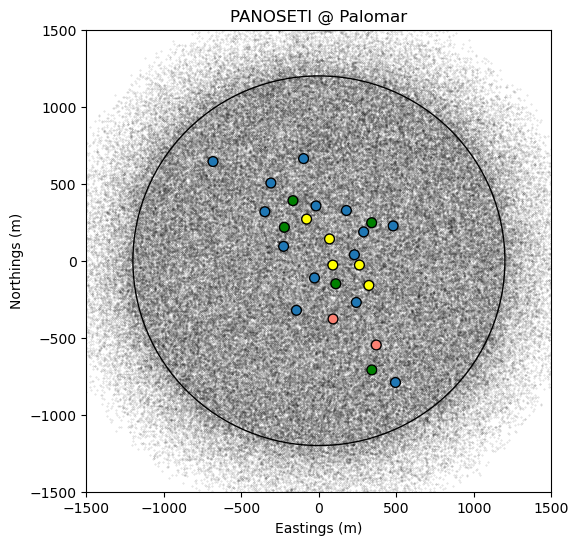

In [111]:
fig=plt.figure(figsize=(6,6))
ax=plt.subplot()
ax.scatter(df_sims.drop_duplicates(subset="Event").TrueXcore, df_sims.drop_duplicates(subset="Event").TrueYcore, color='black', alpha=0.2, s=0.1)
plotArray(ax)

In [112]:
valid_arrays[0]

site_name   longitude   latitude     altitude           X           Y  \
0  Ferns-North -116.865566  33.358478  1684.662094 -167.412855  390.006954   
1       Winter -116.866163  33.356923  1699.172001 -222.895597  217.090243   
2     PTI-Heli -116.864617  33.357401  1689.703579  -79.281409  270.253881   

           Z  priority   color    distance  
0  34.662094         1   green  424.420179  
1  49.172001         1   green  311.144051  
2  39.703579         2  yellow  281.642862

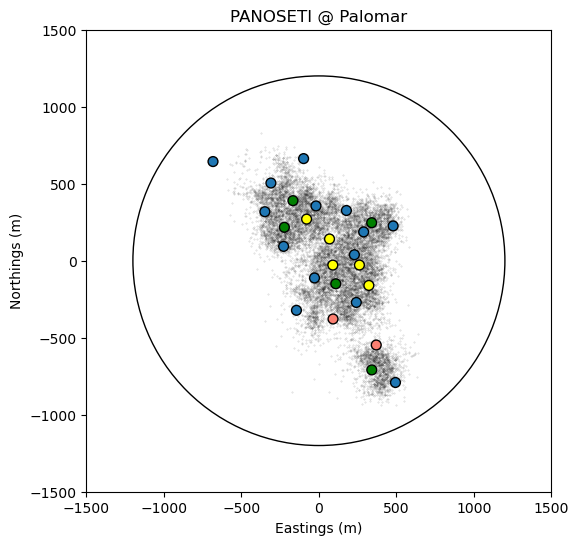

In [113]:
fig=plt.figure(figsize=(6,6))
ax=plt.subplot()
triggered=df_sims.groupby('Event', group_keys=False).filter(lambda x: len(x) > 1).dropna(subset=['Az','Ze']).drop_duplicates(subset='Event')
ax.scatter(triggered.TrueXcore,triggered.TrueYcore,color='black',alpha=0.2,s=0.1)
plotArray(ax)

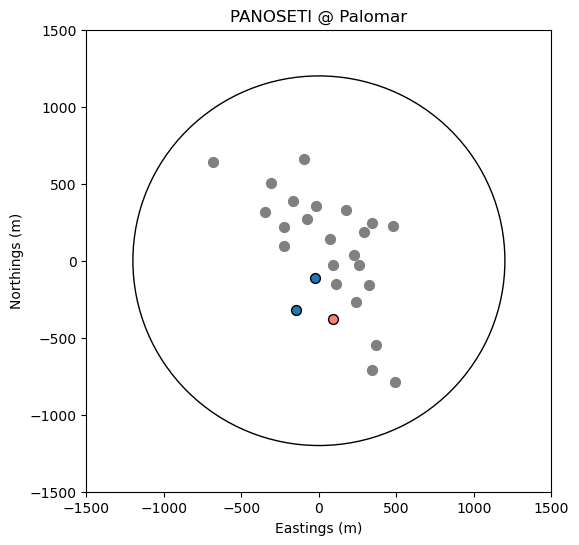

In [114]:
fig=plt.figure(figsize=(6,6))
ax=plt.subplot()
plotArray(ax,highlight=valid_arrays[65])

(0.0, 1.0)

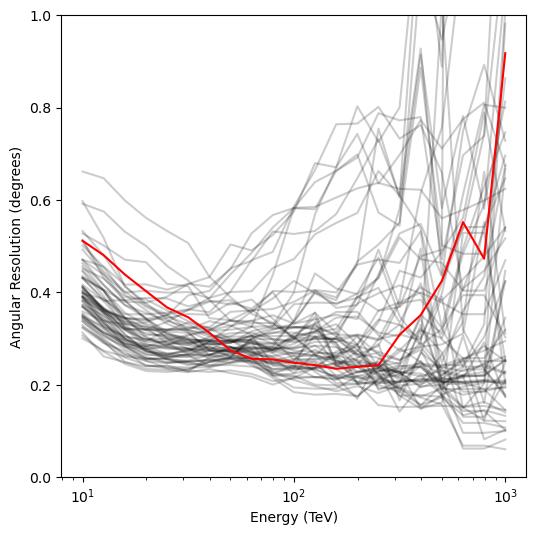

In [115]:
fig=plt.figure(figsize=(6,6))
ax=plt.subplot()
plotPSF(ax,highlight=65)
ax.set_ylim(0,1)
# ax.set_xlim(0,1e2)

<Axes: xlabel='Energy (TeV)', ylabel='Effective Area (km$^2$)'>

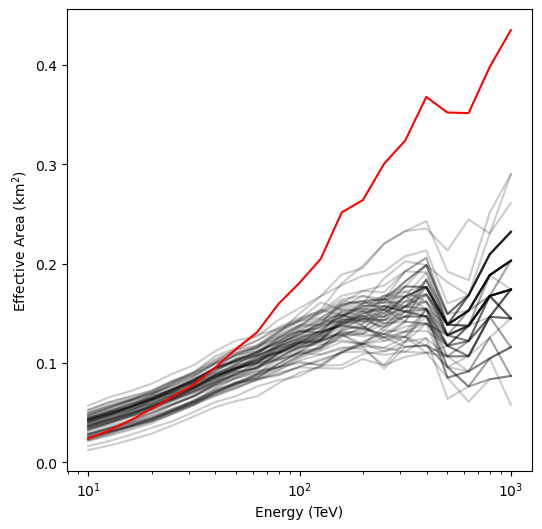

In [116]:
fig=plt.figure(figsize=(6,6))
ax=plt.subplot()
plotAreas(ax,highlight=65)

In [117]:
valid_arrays[65]

site_name   longitude   latitude     altitude           X           Y  \
10   NWS South -116.862783  33.351570  1651.268068   91.129896 -378.259008   
13  East Side? -116.865322  33.352077  1651.604392 -144.821485 -321.927199   
15  East Road? -116.864068  33.353965  1685.235066  -28.312933 -111.903192   

            Z  priority     color    distance  
10   1.268068         3    salmon  389.081656  
13   1.604392         0  tab:blue  353.001960  
15  35.235066         0  tab:blue  115.429401

In [118]:
sims[(sims.Telescope.isin(valid_arrays[0].index)) & (sims.TrueEnergy > energies[15])].describe()

Event  Telescope      MeanX      MeanY         Phi  \
count  5.800000e+01  58.000000  58.000000  58.000000   58.000000   
mean   9.187315e+05   1.517241  -0.026874  -0.270800  188.898165   
std    1.194667e+06   0.504067   1.180919   1.210346  135.751145   
min    1.715600e+04   1.000000  -2.429940  -2.197110    1.954600   
25%    4.458350e+04   1.000000  -0.943787  -1.280558   56.625275   
50%    8.300800e+04   2.000000  -0.147641  -0.338077  273.045500   
75%    2.529828e+06   2.000000   0.949798   0.787771  320.670500   
max    2.590237e+06   2.000000   2.101420   2.037460  353.980000   

                Size     Length      Width      TrueAz     TrueZe  \
count      58.000000  58.000000  58.000000   58.000000  58.000000   
mean    23390.862069   0.351156   0.208621  186.945522  15.714940   
std     55778.605117   0.090091   0.040061   98.108952   3.243563   
min       281.000000   0.161586   0.104079   20.527000   7.915710   
25%      1650.000000   0.280615   0.197209   92.330950  14.507075   
50%      5194.500000   0.356286   0.219414  194.884000  16.535700   
75%     19635.250000   0.424340   0.230486  265.080000  18.063000   
max    386167.000000   0.524083   0.349327  362.622000  19.827900   

         TrueEnergy  
count  5.800000e+01  
mean   8.692059e+05  
std    1.013614e+06  
min    3.217910e+05  
25%    3.711575e+05  
50%    4.909450e+05  
75%    8.185110e+05  
max    6.312420e+06

# Anticorrelation?

/home/nkorzoun/Software/miniconda3/envs/panoseti/lib/python3.11/site-packages/matplotlib/cbook.py:1699: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)


Text(0.5, 1.0, '1000 TeV')

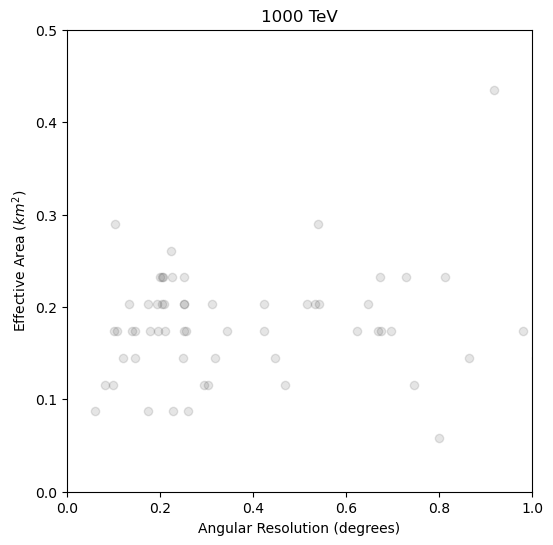

In [119]:
a=[]
r=[]
index=20
# energies[10] is 100 TeV threshold
for i in areas:
    a.append(i[index])
for j in resolutions:
    r.append(j[index])

fig=plt.figure(figsize=(6,6))
ax=plt.subplot()
ax.scatter(r,a,color='black',alpha=0.1)
ax.set_ylabel(r'Effective Area ($km^2$)')
ax.set_xlabel('Angular Resolution (degrees)')
ax.set_xlim(0,1)
ax.set_ylim(0,0.5)
ax.set_title("{:.0f} TeV".format(energies[index]/1e3))


# Proposals

In [120]:
test_arrays=[
    # triangle
    df[df.site_name.isin(["Ferns-North","Winter","PTI-Heli"])].copy(),

    # triangle + 200-inch East
    df[df.site_name.isin(["Ferns-North","Winter","PTI-Heli","200-inch East"])].copy(),
    df[df.site_name.isin(["Ferns-North","Winter","PTI-Heli","200-inch East","Dog Seismo"])].copy(),

    # triangle + Oschin
    df[df.site_name.isin(["Ferns-North","Winter","PTI-Heli","Oschin"])].copy(),
    df[df.site_name.isin(["Ferns-North","Winter","PTI-Heli","Oschin","Dog Seismo"])].copy(),

    # triangle + 200-inch East + Oschin
    df[df.site_name.isin(["Ferns-North","Winter","PTI-Heli","200-inch East", "Oschin"])].copy(),
    df[df.site_name.isin(["Ferns-North","Winter","PTI-Heli","200-inch East","Oschin", "Dog Seismo"])].copy(),

    # triangle + another triangle
    df[df.site_name.isin(["Ferns-North","Winter","PTI-Heli","200-inch East","18-inch North ", "Monastery North"])].copy(),
    df[df.site_name.isin(["Ferns-North","Winter","PTI-Heli","Dog Seismo","18-inch North ", "Monastery North"])].copy(),
    df[df.site_name.isin(["Ferns-North","Winter","PTI-Heli","200-inch East", "Dog Seismo","18-inch North ", "Monastery North"])].copy(),

    # triangle + another triangle + Oschin
    df[df.site_name.isin(["Ferns-North","Winter","PTI-Heli","Oschin","200-inch East","18-inch North ", "Monastery North"])].copy(),
    df[df.site_name.isin(["Ferns-North","Winter","PTI-Heli","Oschin","Dog Seismo","18-inch North ", "Monastery North"])].copy(),
    df[df.site_name.isin(["Ferns-North","Winter","PTI-Heli","Oschin","200-inch East", "Dog Seismo","18-inch North ", "Monastery North"])].copy(),

    # triangle + all green
    df[df.site_name.isin(["Ferns-North","Winter","PTI-Heli","Oschin", "60-inch West", "Dog Seismo"])].copy(),

    # quad
    df[df.site_name.isin(["18-inch North ", "Dog Seismo","Monastery North","Monastery South"])].copy(),

    # quad + 200-inch
    df[df.site_name.isin(["200-inch East","18-inch North ", "Dog Seismo","Monastery North","Monastery South"])].copy()
    
]

## Calculate FoM

In [121]:
energies = np.logspace(4,6,21)
resolutions = []
areas = []
multiplicity = []

# calculate
for array in test_arrays:
    # print(array)
    psf=[]
    area=[]

    data=sims[sims.Telescope.isin(array.index+1)].copy()
    data=reconstruct_direction(data)

    for e in energies:
        psf.append(calcPSF(data,threshold=e))
        area.append(calcEffA(data,threshold=e))

    resolutions.append(psf)
    areas.append(area)

    # how many telescopes triggered in each array?
    ntel=[0 for i in range(data.Telescope.nunique()-1)]
    for i in range(data.Telescope.nunique()-1):
        num = len(data.groupby('Event', group_keys=False).filter(lambda x: len(x) > i+1))
        ntel[i]=num
    multiplicity.append(ntel)



In [122]:
multiplicity

# [2 tel, 3 tel, 4 tel, ...]

[[3481, 1437],
 [4459, 1731, 204],
 [4700, 1764, 225, 5],
 [3514, 1438, 4],
 [3558, 1454, 8, 0],
 [4734, 1774, 205, 5],
 [4965, 1837, 226, 10, 0],
 [7278, 2570, 359, 39, 24],
 [7073, 2879, 74, 26, 6],
 [9161, 3841, 691, 91, 31, 7],
 [7692, 2704, 505, 65, 25, 7],
 [7367, 2979, 135, 27, 12, 0],
 [9575, 3975, 807, 167, 32, 14, 0],
 [3560, 1454, 8, 0, 0],
 [5514, 2016, 768],
 [6795, 2671, 1036, 160]]

In [123]:
# longest baseline?
for array in test_arrays:
    points=[]
    for j in range(len(array)):
        telescope = array.iloc[j]
        points.append((telescope.X,telescope.Y))

    distances = pdist(points)
    print(np.max(distances))


181.59989967647925
342.7547379183877
606.2880163778802
564.1961898510674
606.2880163778802
564.1961898510674
606.2880163778802
598.8021133451639
606.2880163778802
606.2880163778802
598.8021133451639
606.2880163778802
606.2880163778802
1211.0821684879404
267.5256469891515
394.3527448961284


In [124]:
vals = []
for r in resolutions:
    vals.append(r[11].values)

print([sorted(vals).index(x) + 1 for x in vals])

[10, 6, 9, 14, 15, 8, 12, 2, 7, 1, 4, 11, 3, 16, 13, 5]


In [125]:
vals = []
for a in areas:
    vals.append(a[11])

print([len(vals) - sorted(vals).index(x) for x in vals])


[16, 14, 9, 15, 13, 11, 8, 6, 5, 4, 3, 2, 1, 12, 10, 7]


## Plot

In [126]:
# range of 0 to len(test_arrays)
h=9

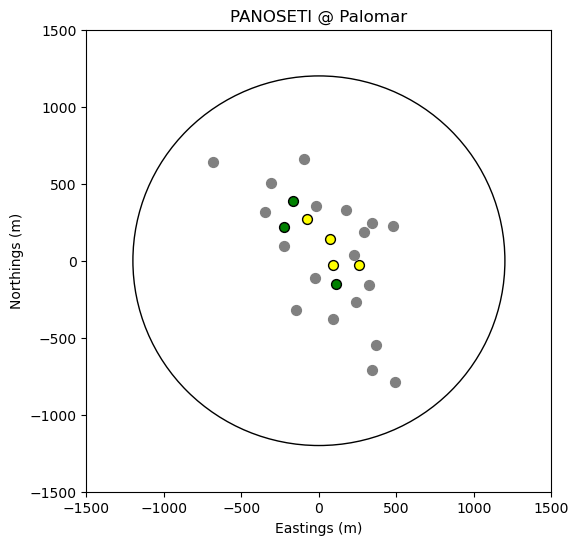

In [127]:
fig=plt.figure(figsize=(6,6))
ax=plt.subplot()
plotArray(ax,highlight=test_arrays[h])

<Axes: xlabel='Energy (TeV)', ylabel='Angular Resolution (degrees)'>

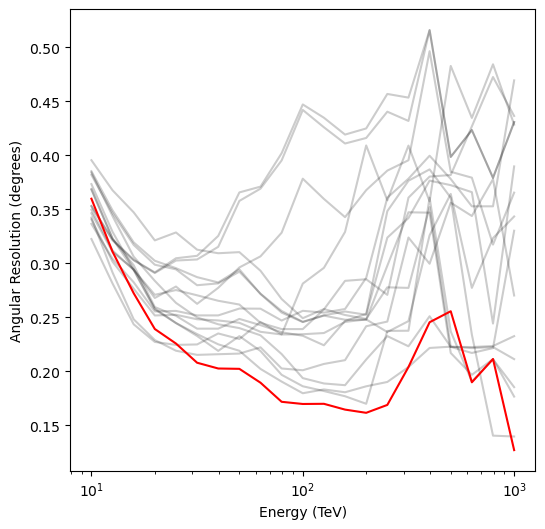

In [128]:
fig=plt.figure(figsize=(6,6))
ax=plt.subplot()
plotPSF(ax,highlight=h,reference=test_arrays)

<Axes: xlabel='Energy (TeV)', ylabel='Effective Area (km$^2$)'>

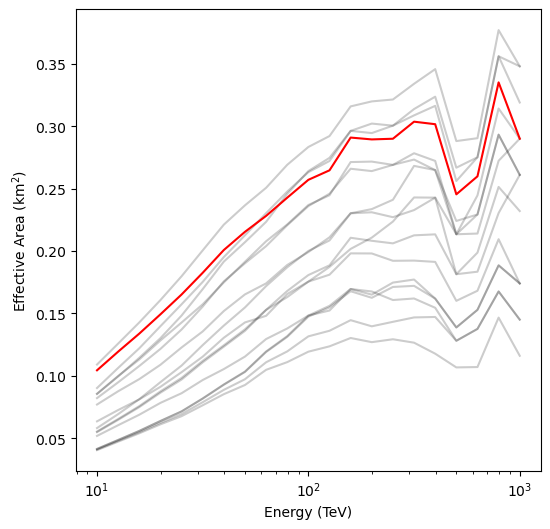

In [129]:
# ax.set_ylim(0,1)
# ax.set_xlim(0,1e2)
fig=plt.figure(figsize=(6,6))
ax=plt.subplot()
plotAreas(ax,highlight=h,reference=test_arrays)

/tmp/ipykernel_809656/2817733685.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig=plt.figure(figsize=(6,6))


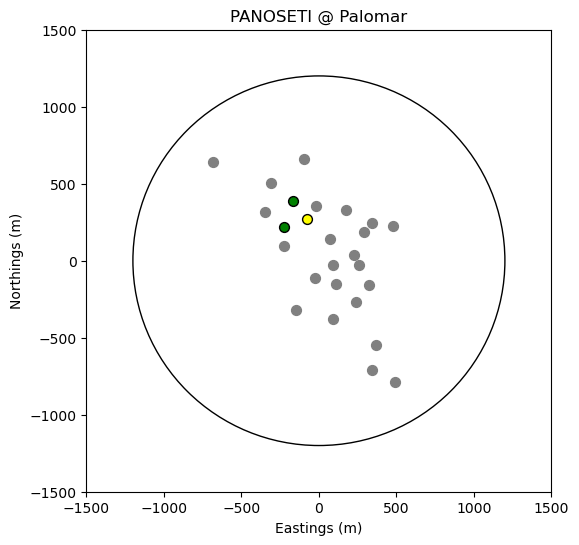

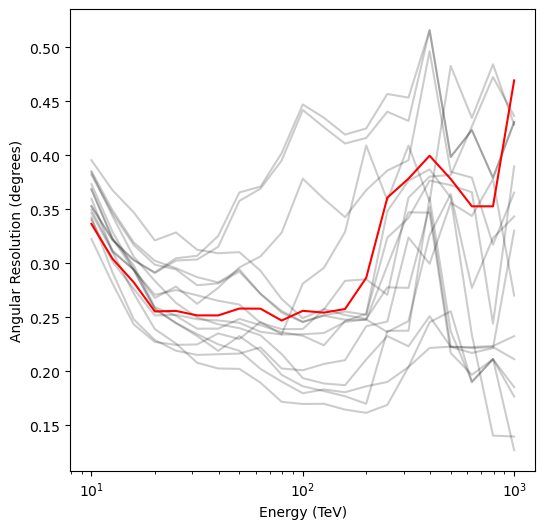

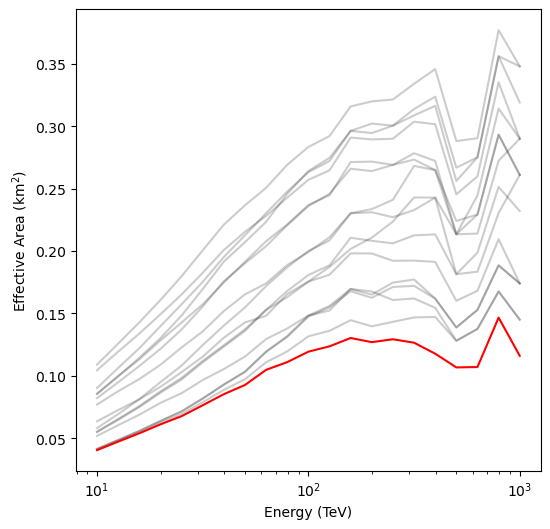

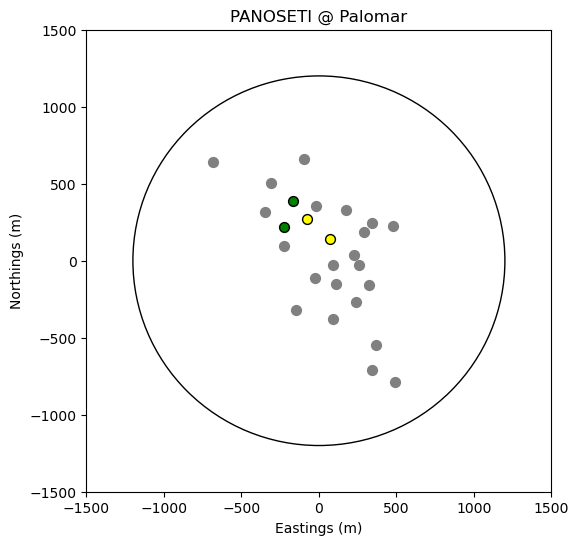

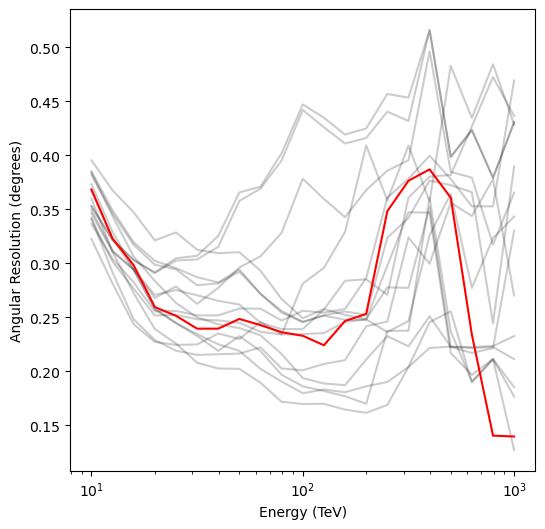

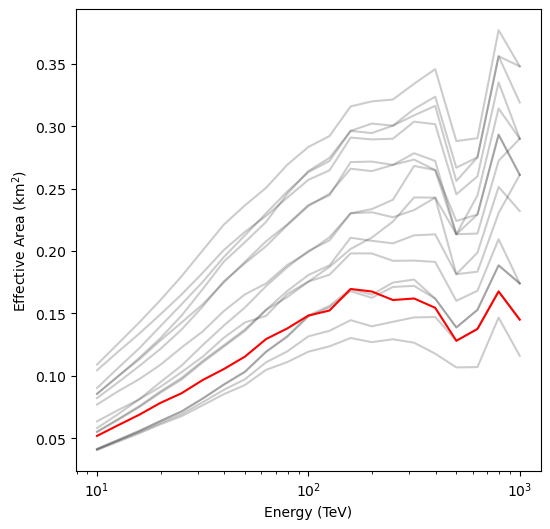

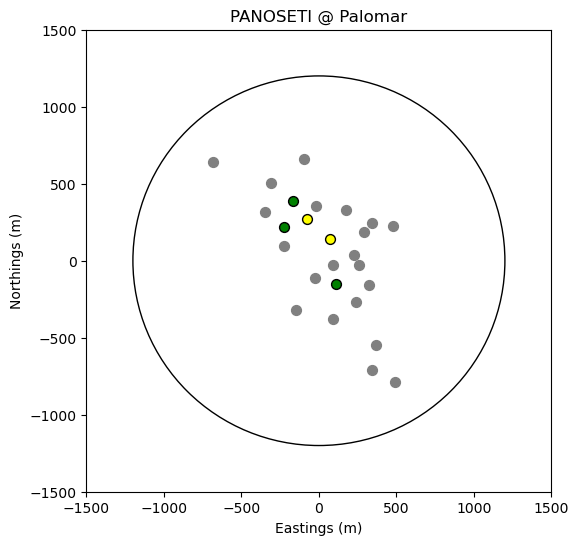

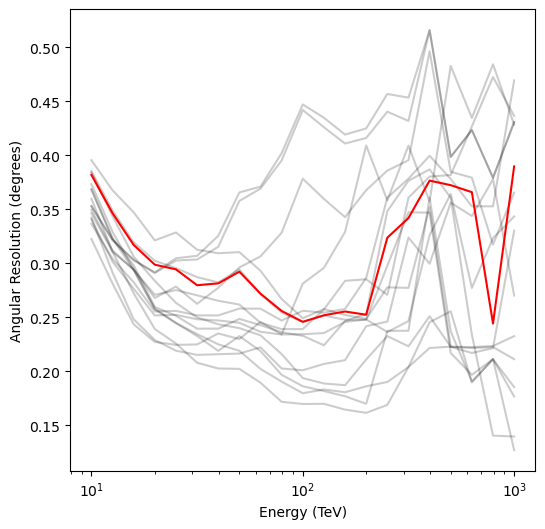

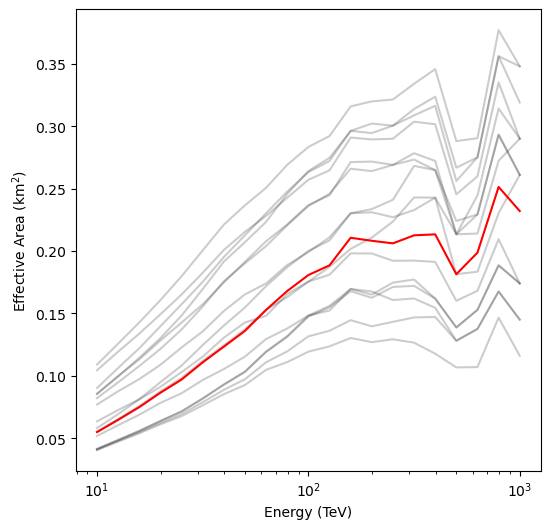

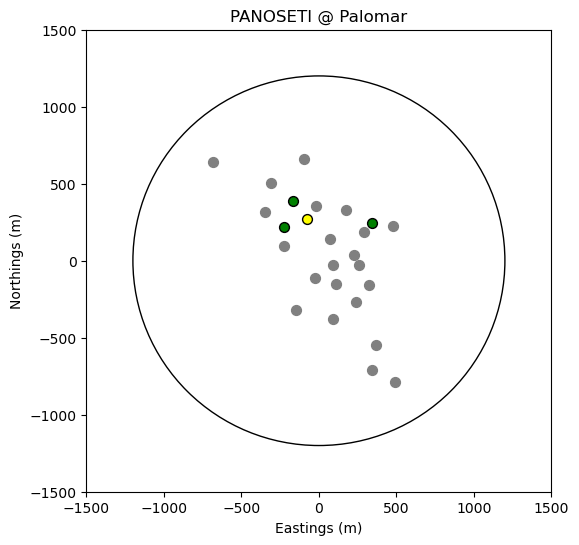

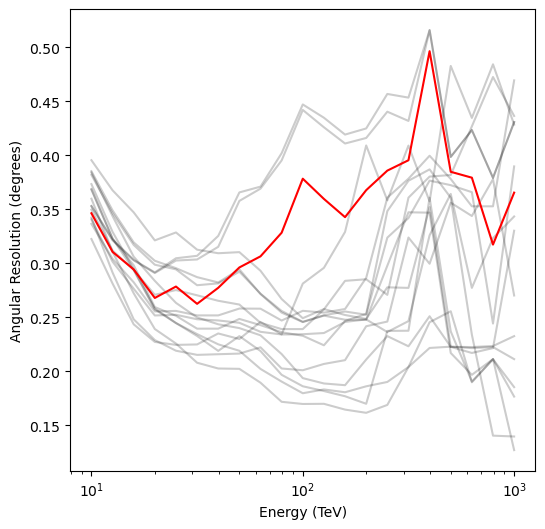

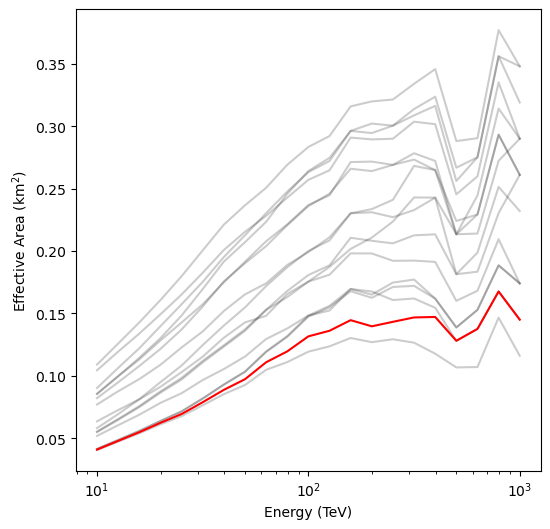

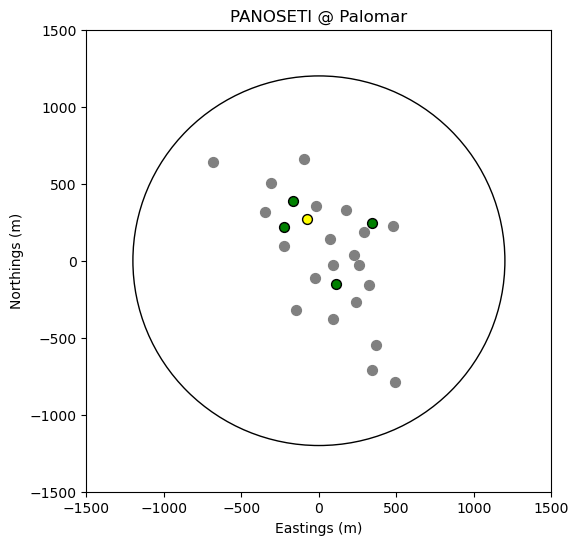

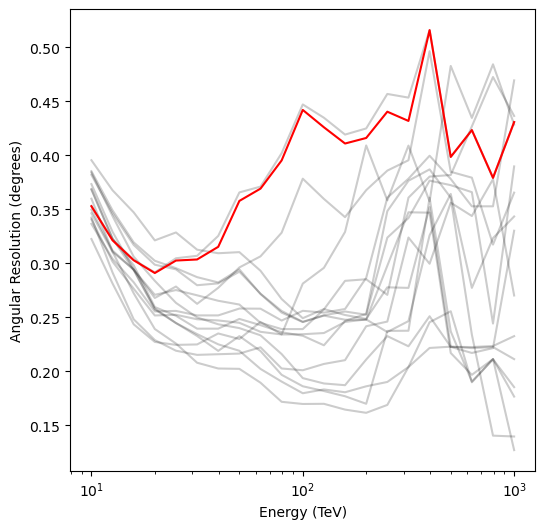

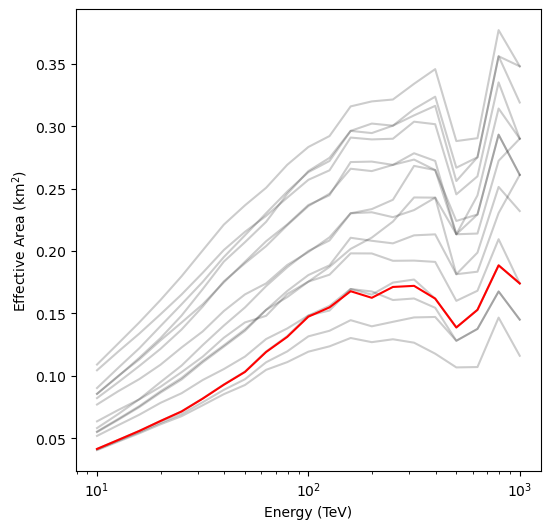

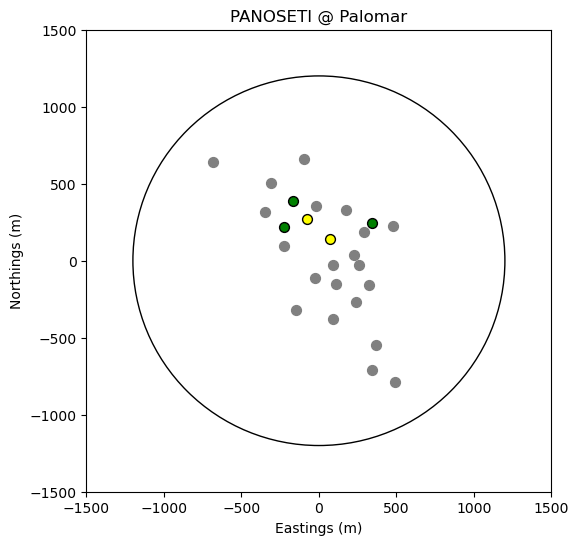

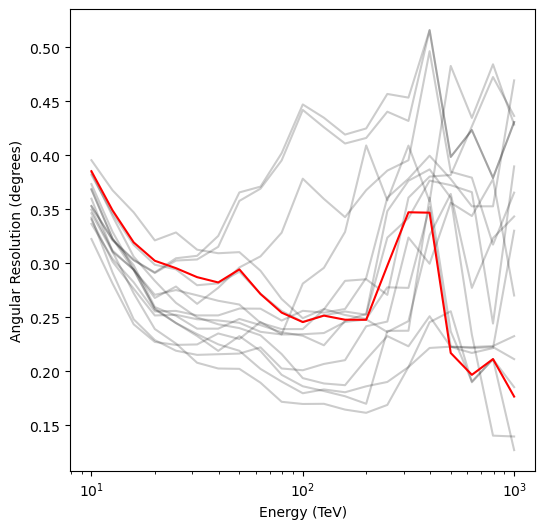

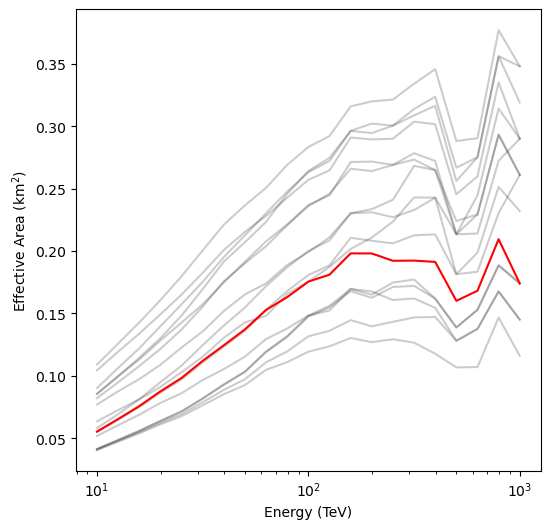

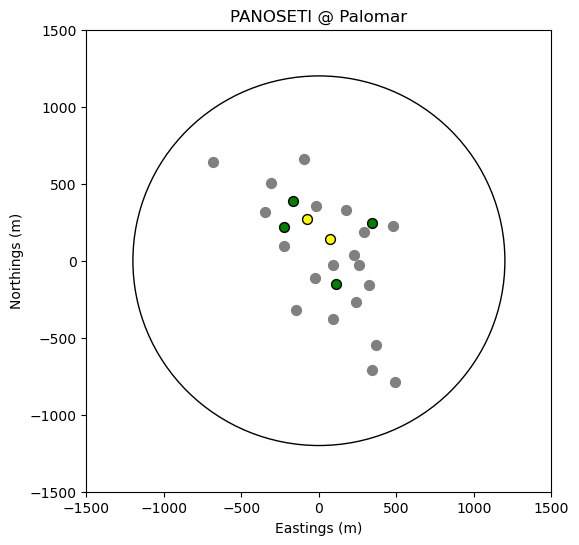

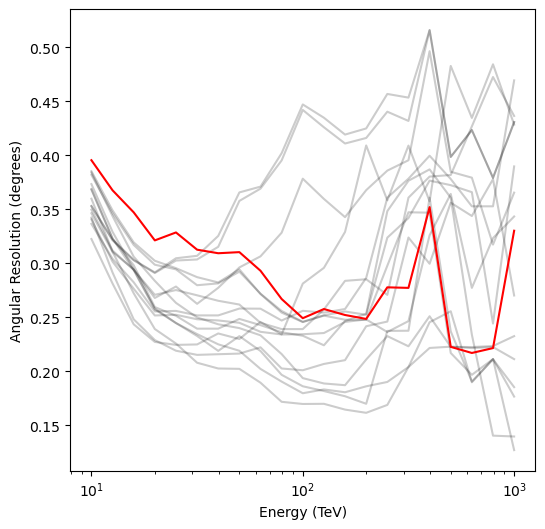

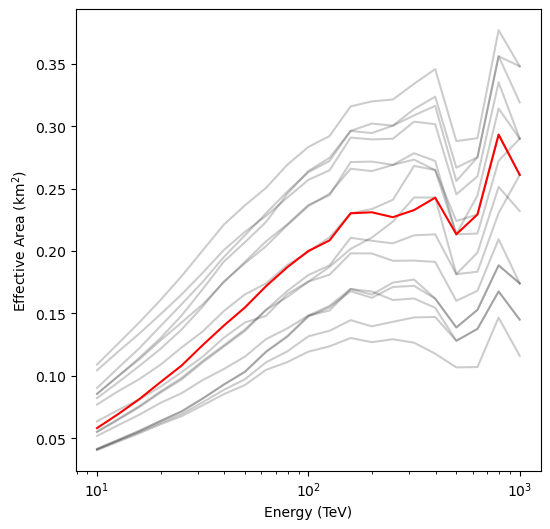

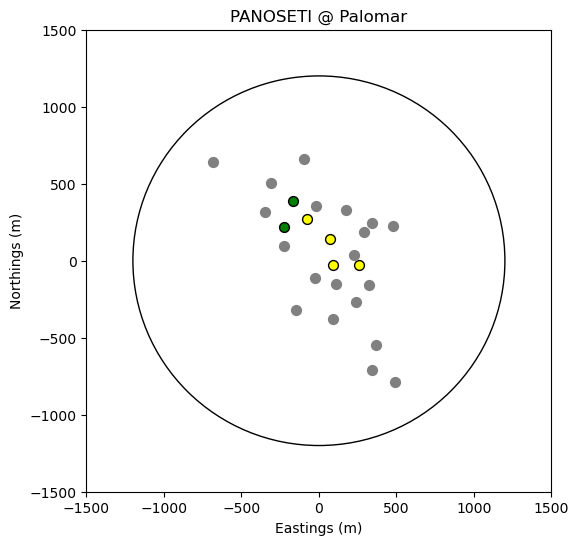

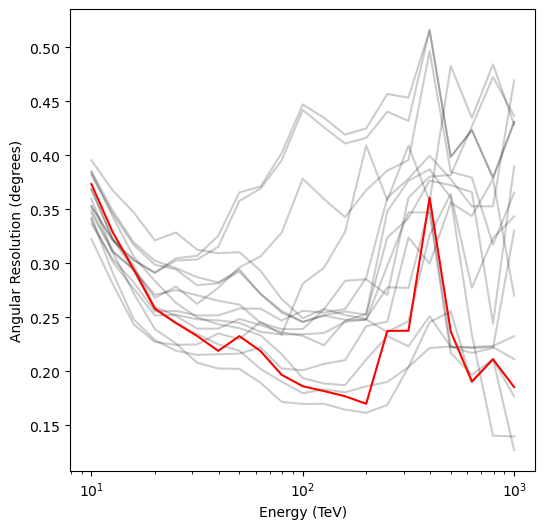

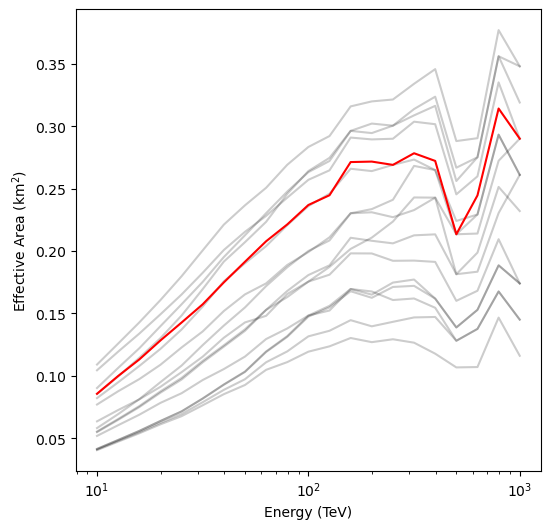

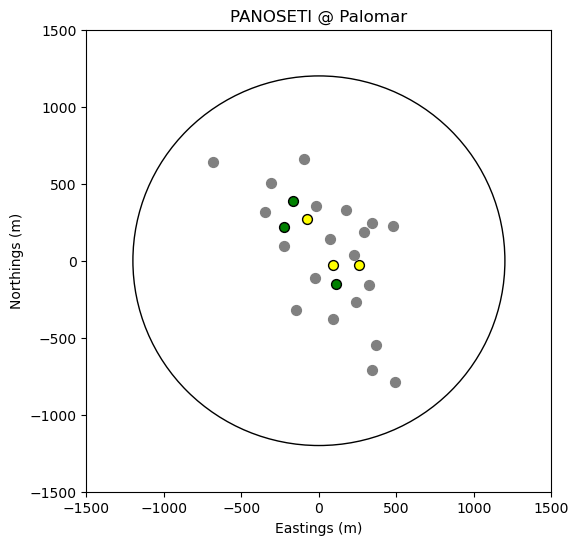

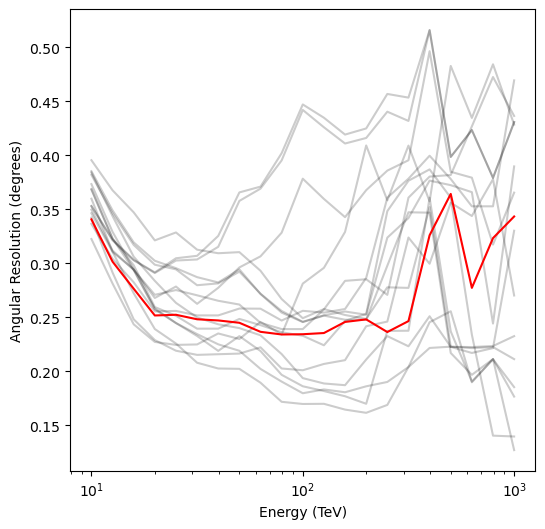

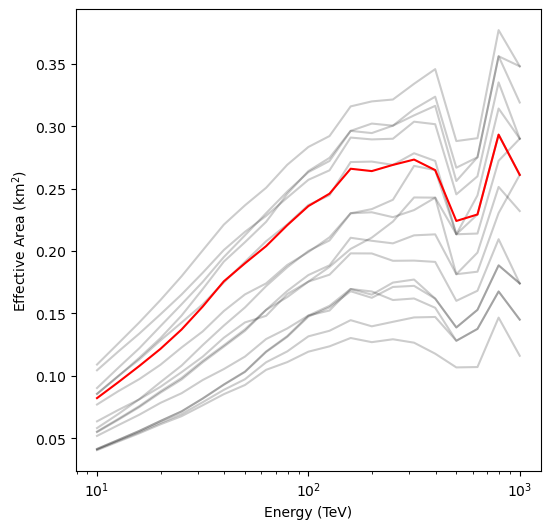

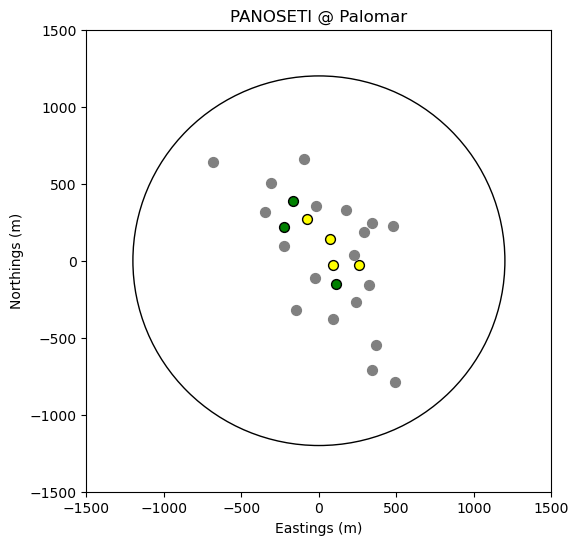

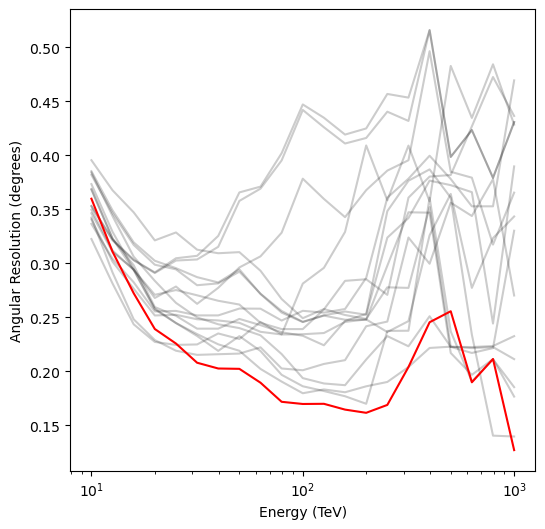

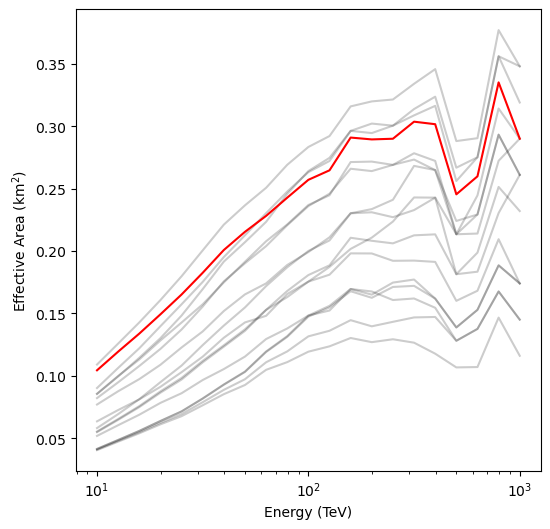

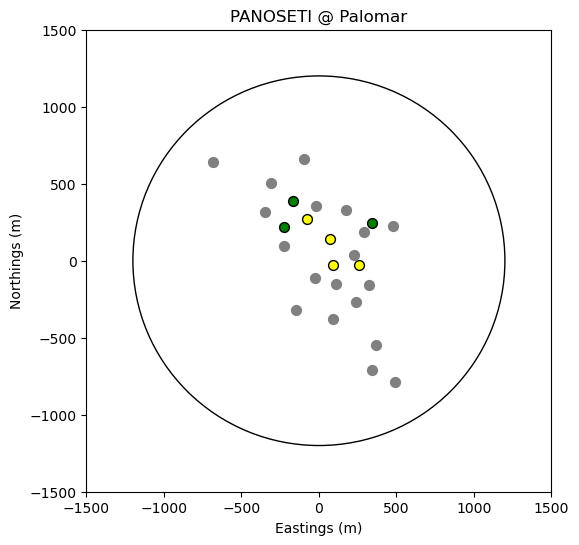

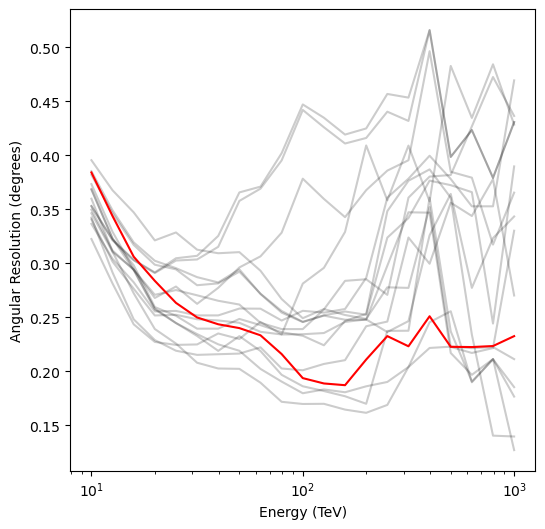

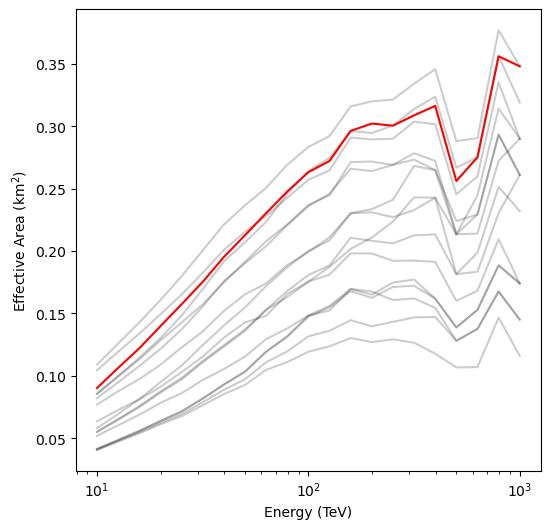

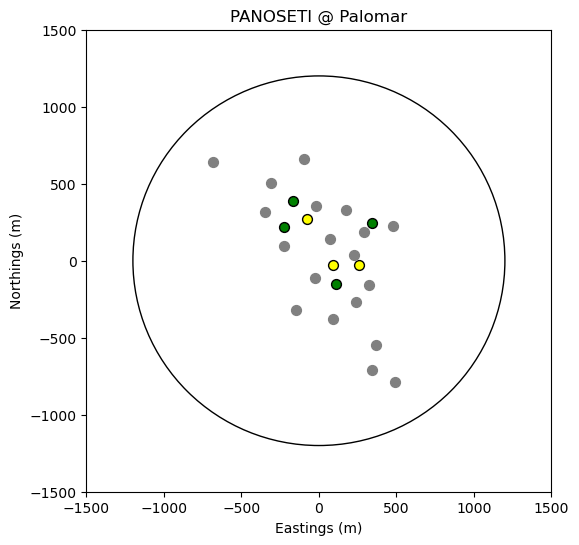

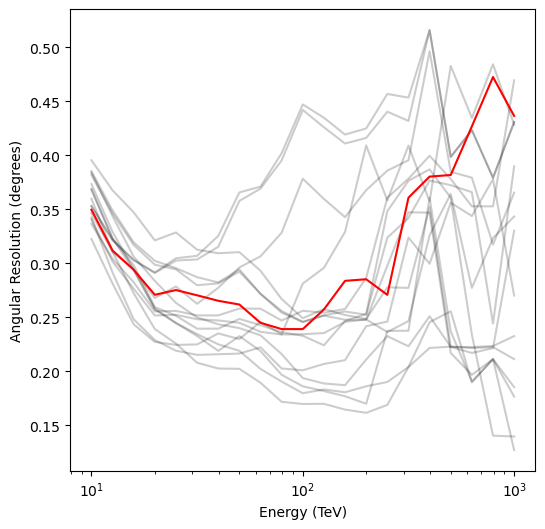

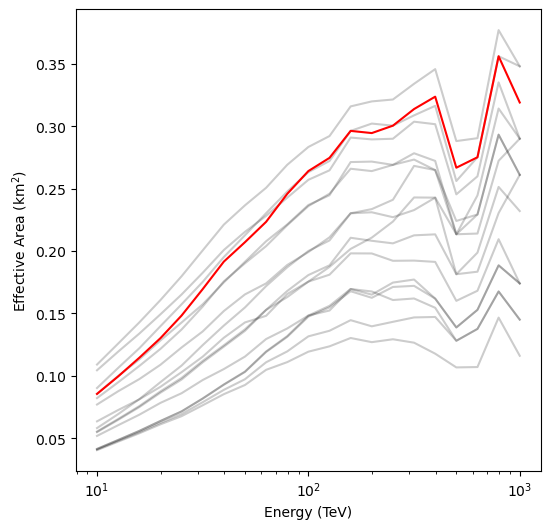

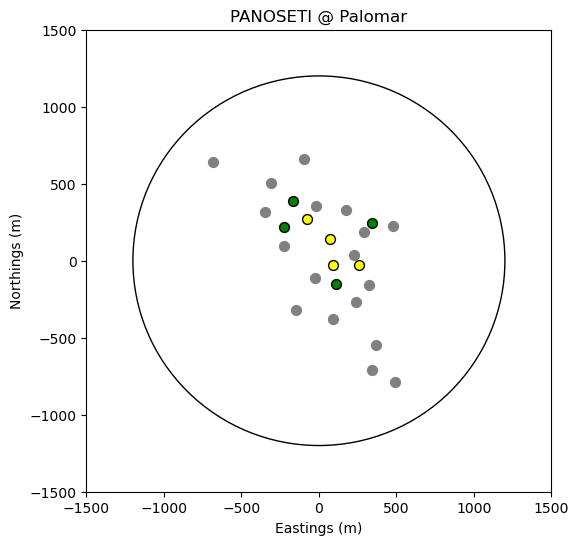

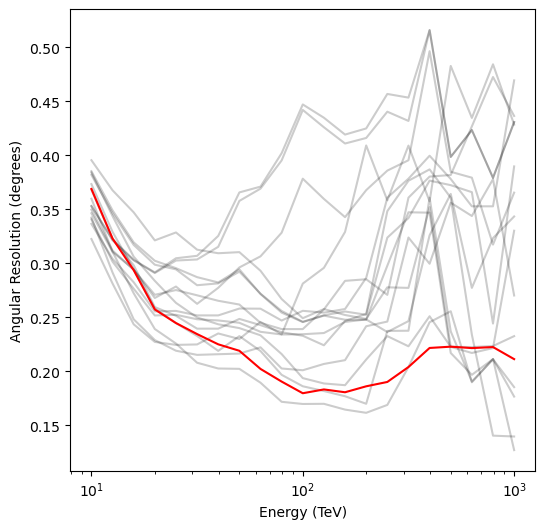

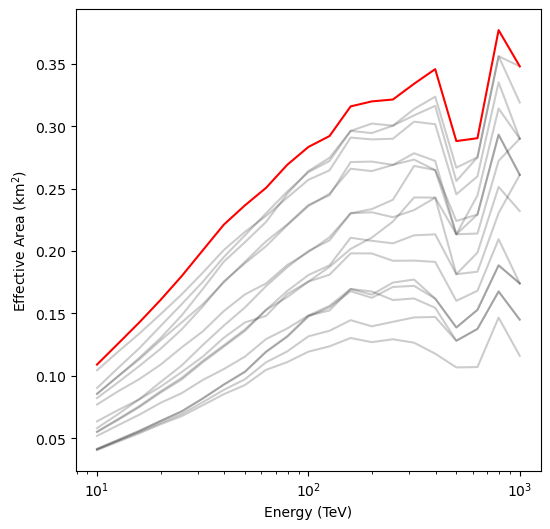

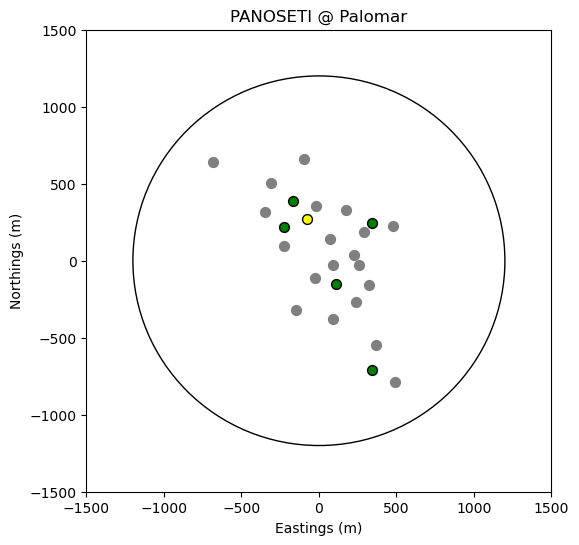

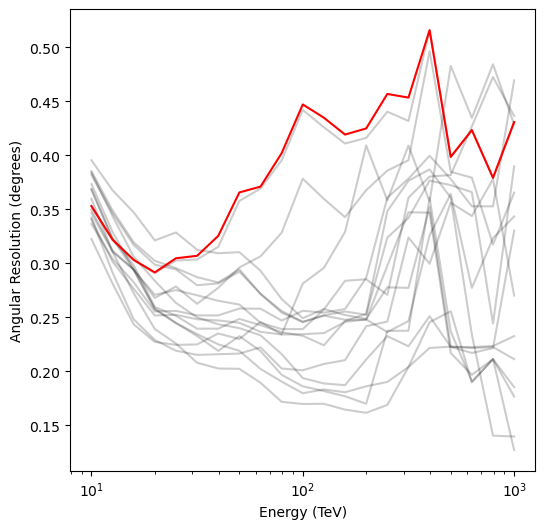

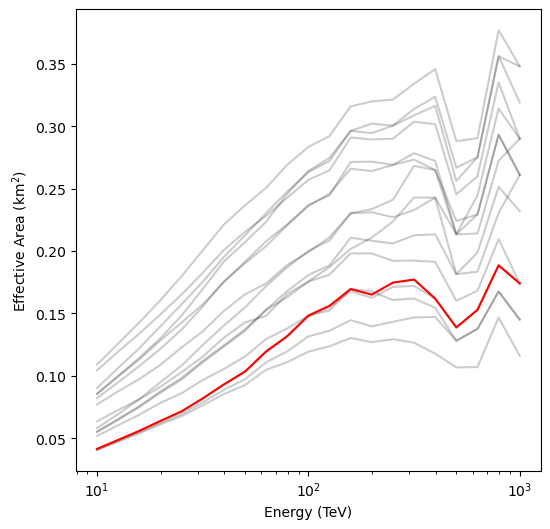

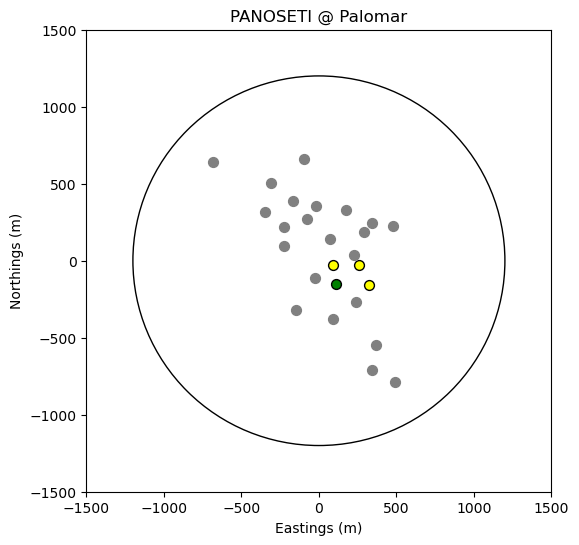

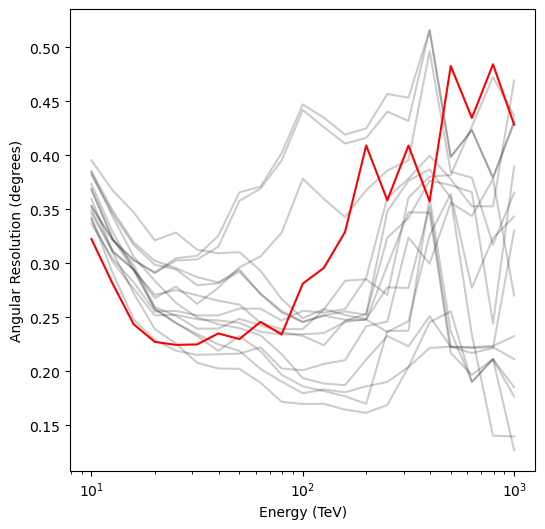

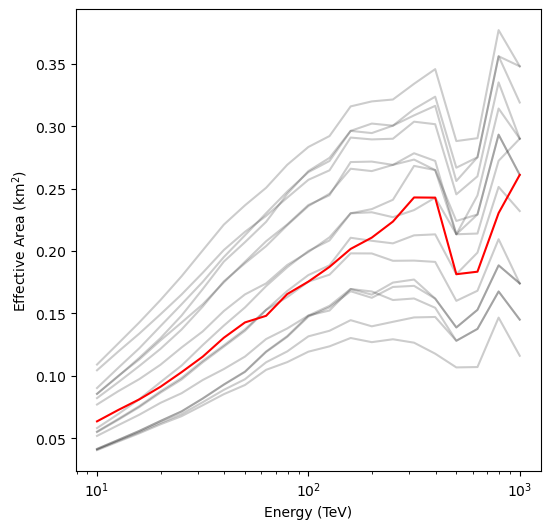

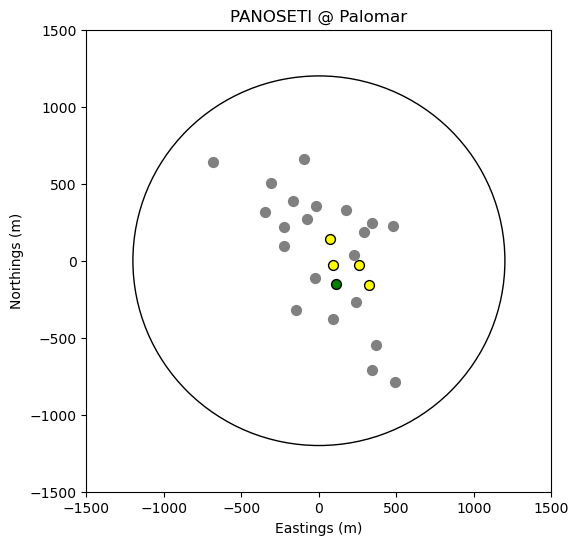

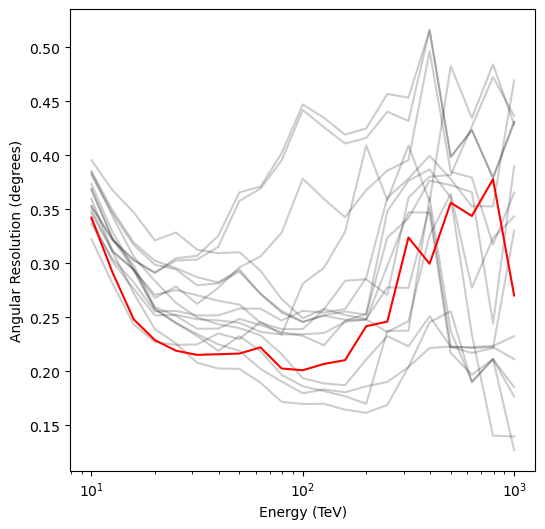

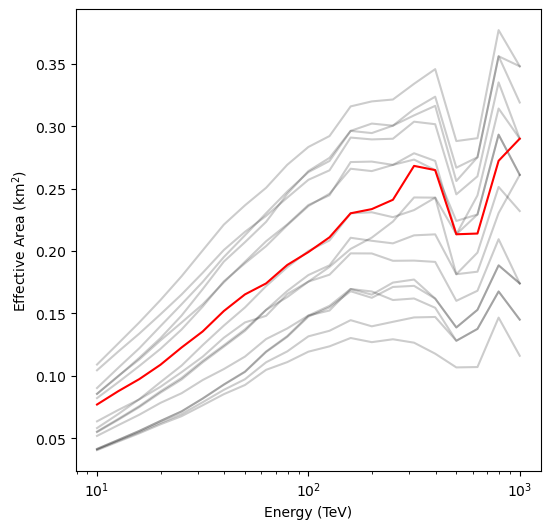

In [130]:
for h in range(len(test_arrays)):
    fig=plt.figure(figsize=(6,6))
    ax=plt.subplot()
    plotArray(ax,highlight=test_arrays[h])
    plt.savefig('../../../../Downloads/{}-1.png'.format(h))

    fig=plt.figure(figsize=(6,6))
    ax=plt.subplot()
    plotPSF(ax,highlight=h,reference=test_arrays)
    plt.savefig('../../../../Downloads/{}-2.png'.format(h))

    fig=plt.figure(figsize=(6,6))
    ax=plt.subplot()
    plotAreas(ax,highlight=h,reference=test_arrays)
    plt.savefig('../../../../Downloads/{}-3.png'.format(h))